In [500]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (20,7)

In [501]:
countries_mapping = {
    "134": "Germany",
    "111": "UnitedStates",
    "132": "France",
    "193": "Australia",
    "156": "Canada",
    "112": "UnitedKingdom",
    "122": "Austria",
    "124": "BelgiumLuxembourg",
    "138": "NetherlandsThe",
    "136": "Italy",
    "124": "Belgium",
    "128": "Denmark",
    "142": "Norway",
    "144": "Sweden",
    "146": "Switzerland",
    "158": "Japan",
    "174": "Greece",
    "172": "Finland",
    "184": "Spain",
    "178": "Ireland",
    "182": "Portugal",
    "196": "NewZealand"
}
list_countries = [
    'Australia', 'Austria', 'Canada', 'Denmark',
    'Finland', 'France', 'Germany', 'Greece',
    'Ireland', 'Italy', 'Japan', 'NewZealand',
    'Norway', 'Portugal', 'Spain', 'Sweden',
    'Switzerland', 'UnitedKingdom', 'UnitedStates'
]

In [523]:
def clean_trade_dataset(df):
    """
    Takes the df as provided by the imf and returns it as a clean and usable dataframe
    """
    df_transposed = df.iloc[5:,1:].T
    df_transposed.columns = df_transposed.iloc[0]
    df_transposed = df_transposed.iloc[1:, :]
    df_transposed.rename(columns={np.nan: "Year"}, inplace=True)
    df_transposed["Year"] = df_transposed["Year"].astype("int")
    df_transposed = df_transposed.set_index("Year")
    return df_transposed

def process_nominal_GDP(df):
    df = df.set_index("Year")
    df = df.replace("...", np.nan)
    for column in df.columns:
        df = df.astype({column:'float'})
    df = df.rename(columns={
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
        "New Zealand": "NewZealand",
        "Netherlands, The": 'NetherlandsThe',
    })
    return df.loc[1960:]

def process_real_GDP(df):
    df.columns = df.loc["Country"]
    df = (
        df
        .iloc[3:, ]
        .replace("...", np.nan)
        .rename(columns={
            "New Zealand": "NewZealand",
            "Netherlands, The": 'NetherlandsThe',
            "United States": "UnitedStates",
            "United Kingdom": "UnitedKingdom",
        })
    )

    for column in df.columns:
        df[column] = df[column].str.replace(" ","")
        df = df.astype({column:'float'})
    
    df = df.rename(columns={"Country": "date"})
    df["year"] = df.index.str[:4].astype(int)
    df["quarter"] = df.index.str[4:]
    df["month"] = df["quarter"].replace({"Q1": 1, "Q2": 4, "Q3": 7, "Q4": 10})
    df['date'] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
    df = df.set_index("date")
    return df

def get_trade_activity(country_i, country_j, dict_export, dict_import, real_GDP_yearly, nominalGDP):
    """
    Takes 2 countries as input
    Returns a dataframe with trade activity between these two countries
    X_i_j: export from country i to j
    X_i: total global export from country i
    M_i_j: import of country i from j
    M_i: total global import of country i
    Y_i: GDP of country i
    """
    X_i_j = dict_export[country_i][[country_j]].rename(columns={country_j: f"Export from {country_i} to {country_j}"})
    X_i = dict_export[country_i][["World"]].rename(columns={"World": f"Global Export from {country_i} to world"})
    X_j = dict_export[country_j][["World"]].rename(columns={"World": f"Global Export from {country_j} to world"})
    M_i_j = dict_import[country_i][[country_j]].rename(columns={country_j: f"Import of {country_i} from {country_j}"})
    M_i = dict_import[country_i][["World"]].rename(columns={"World": f"Global Import of {country_i}"})
    M_j = dict_import[country_j][["World"]].rename(columns={"World": f"Global Import of {country_j}"})
    Y_real_i = real_GDP_yearly[[country_i]].rename(columns={country_i: f"GDP of {country_i}"})
    Y_real_j = real_GDP_yearly[[country_j]].rename(columns={country_j: f"GDP of {country_j}"})
    Y_nominal_i = nominalGDP[[country_i]].rename(columns={country_i: f"GDP of {country_i}"})
    Y_nominal_j = nominalGDP[[country_j]].rename(columns={country_j: f"GDP of {country_j}"})
    W_i_j = pd.concat([X_i_j, X_i, M_i_j, M_i, X_j, M_j, Y_real_i, Y_real_j,Y_nominal_i, Y_nominal_j], axis=1)
    W_i_j["wt: Trade Intensity by bilateral trade"] = (X_i_j.values + M_i_j.values) / (X_i.values + X_j.values + M_i.values + M_j.values)
    W_i_j["wy_real: Trade Intensity by real GDP"] = (X_i_j.values + M_i_j.values) / (Y_real_i.values + Y_real_j.values)
    W_i_j["wy_nominal: Trade Intensity by nominal GDP"] = (X_i_j.values + M_i_j.values) / (Y_nominal_i.values + Y_nominal_j.values)
    W_i_j["wm"] = M_i_j.values / (M_i.values + M_j.values)
    W_i_j["wx"] = X_i_j.values / (X_i.values + X_j.values)
    for column in W_i_j.columns:
        W_i_j[column] = W_i_j[column].astype(float)
    return W_i_j

def get_average_period(df_trade_activity, date1, date2, country_i, country_j):
    ta_ci_cj = df_trade_activity[country_i][country_j]
    ta_ci_cj = ta_ci_cj[(ta_ci_cj.index >= date1) & (ta_ci_cj.index <= date2)]
    ta_ci_cj = ta_ci_cj.sort_index()
    return np.abs(pd.DataFrame(
                ta_ci_cj[["wt: Trade Intensity by bilateral trade",
                          "wy_real: Trade Intensity by real GDP",
                          "wy_nominal: Trade Intensity by nominal GDP",
                          "wm",
                          "wx"]]).loc[date1:date2].mean()).T

def process_concept_data(df):
    df = df[["Value", "TIME", "Country"]]
    df["Value"] = np.log(df["Value"])
    df["Year"] = df["TIME"].astype(str).str[:4]
    df["Quarter"] = df["TIME"].astype(str).str[-1].astype(int)
    df["Month"] = (df["Quarter"]-1)*3+1
    df['Date'] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1))
    return df

Process:
For the economic concepts (left side of regression equation: real GDP, employment, unemployment):
-> de-trend data with 4 methods (so far HP filter and 4th lag)
-> get correlation over each period between each pair of countries available)

For the bilateral trade intensity (right side of the regression equation, based on nominal GDP):
-> Get bilateral trade concept (wx, wm, wt) between each pair of countries available
-> Get average over each period


In [503]:
path_nominal_GDP = "data_StatApp/imf/NominalGDP.xls"
xls_nominalGDP = pd.ExcelFile(path_nominal_GDP)
nominalGDP = pd.read_excel(xls_nominalGDP, 'Sheet1')

path_real_GDP = "/Users/victorgraff/Documents/2022:2023 ENSAE/Cours/Statapps/data_StatApp/imf/real_GDP_corrected.csv"
real_GDP = pd.read_csv(path_real_GDP, on_bad_lines='skip').T

In [504]:
real_GDP.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
Country,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Chile,"China, P.R.: Hong Kong",Colombia,Costa Rica,"Croatia, Rep. of",Cyprus,Czech Rep.,Denmark,Ecuador,El Salvador,"Estonia, Rep. of",Euro Area,Finland,France,Germany,Greece,Honduras,Hungary,India,Indonesia,Ireland,Israel,Italy,Japan,Jordan,"Korea, Rep. of",Latvia,Lithuania,Luxembourg,Malta,Mexico,"Moldova, Rep. of","Netherlands, The",New Zealand,Norway,Philippines,"Poland, Rep. of",Portugal,Romania,Russian Federation,Saudi Arabia,"Serbia, Rep. of",Singapore,Slovak Rep.,"Slovenia, Rep. of",South Africa,Spain,Sweden,Switzerland,Thailand,Turkey,Ukraine,United Kingdom,United States
Scale,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions,Millions
Base Year,2004,2019/2020,2010,2010,1995,2010,2012,2018,2020,2015,2017,2010,2010,2010,2010,2007,2014,2010,2010,2010,2010,2010,2010,2000,2010,2011/2012,2010,2010,2015,2010,2015,NaN,2015,2010,2010,2010,2010,2013,2010,2010,2009/2010,2010,2018,2010,2010,2010,2016,2010,2010,2015,2010,2010,2015,2010,2010,2010,2005,2010,2016,2019,2012
1959Q1,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,131 520.00,780 994.50
1959Q2,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,133 707.00,798 607.30


In [505]:
nominalGDP = process_nominal_GDP(nominalGDP)
real_GDP = process_real_GDP(real_GDP)
real_GDP_yearly = real_GDP.groupby("year").sum()

real_GDP_yearly = real_GDP_yearly.loc[1960:2020]

real_GDP_yearly = real_GDP_yearly.replace(0.0, np.nan)

real_GDP = real_GDP[list_countries]

real_GDP_yearly.head()

Country,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Chile,"China, P.R.: Hong Kong",Colombia,Costa Rica,"Croatia, Rep. of",Cyprus,Czech Rep.,Denmark,Ecuador,El Salvador,"Estonia, Rep. of",Euro Area,Finland,France,Germany,Greece,Honduras,Hungary,India,Indonesia,Ireland,Israel,Italy,Japan,Jordan,"Korea, Rep. of",Latvia,Lithuania,Luxembourg,Malta,Mexico,"Moldova, Rep. of",NetherlandsThe,NewZealand,Norway,Philippines,"Poland, Rep. of",Portugal,Romania,Russian Federation,Saudi Arabia,"Serbia, Rep. of",Singapore,Slovak Rep.,"Slovenia, Rep. of",South Africa,Spain,Sweden,Switzerland,Thailand,Turkey,Ukraine,UnitedKingdom,UnitedStates,month
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960,NaN,277471.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29070100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,576144.0,3262061.2,22
1961,NaN,277569.0,NaN,NaN,NaN,NaN,355591.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31086500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591529.0,3345690.3,22
1962,NaN,292573.0,NaN,NaN,NaN,NaN,381995.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32297200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,597893.0,3550683.8,22
1963,NaN,310885.0,NaN,NaN,NaN,NaN,402430.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35210600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,626797.0,3705317.8,22
1964,NaN,329918.0,NaN,NaN,NaN,NaN,429163.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38546500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,662544.0,3918790.9,22


## Trade activity

#### For each country, aggregation of import and export with all other countries available

In [506]:

dict_paths = {}
dict_xls = {}
# dict export contains a set per country, representing the exports from this country to partners
dict_export = {}
# dict import contains a set per country, representing the imports of this country from partners
dict_import = {}

for country in list_countries:
    dict_paths[country] = f"data_StatApp/imf/trade/{country}.xls"
    dict_xls[country] = pd.ExcelFile(dict_paths[country])
    dict_export[country] = pd.read_excel(dict_xls[country], dict_xls[country].sheet_names[0], index_col=None)
    dict_export[country] = clean_trade_dataset(dict_export[country])\
                            .rename(columns={
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
        "New Zealand": "NewZealand"
    })
    dict_export[country] = dict_export[country].T.drop_duplicates().T
    dict_import[country] = pd.read_excel(dict_xls[country], dict_xls[country].sheet_names[1], index_col=None)
    dict_import[country] = clean_trade_dataset(dict_import[country])\
                            .rename(columns={
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
        "New Zealand": "NewZealand"
    })
    dict_import[country] = dict_import[country].T.drop_duplicates().T
    for column in dict_import[country].columns:
        dict_import[country][column] = dict_import[country][column].astype("float")
        dict_import[country][column] = dict_import[country][column].round(2)


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (528008) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (510643) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (510790) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (510833) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (529451) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size 

In [507]:
dict_import["Germany"].head()

Unnamed: 1,Australia,World,Advanced Economies,Euro Area,Austria,Belgium,Belgium-Luxembourg,Cyprus,"Estonia, Rep. of",Finland,France,Greece,Ireland,Italy,Latvia,Lithuania,Luxembourg,Malta,"Netherlands, The",Portugal,Slovak Rep.,"Slovenia, Rep. of",Spain,Canada,"China, P.R.: Hong Kong","China, P.R.: Macao",Czech Rep.,Denmark,Iceland,Israel,Japan,"Korea, Rep. of",NewZealand,Norway,"San Marino, Rep. of",Singapore,Sweden,Switzerland,Taiwan Province of China,UnitedKingdom,UnitedStates,Holy See,Emerging and Developing Economies,Emerging and Developing Asia,American Samoa,Bangladesh,Bhutan,Brunei Darussalam,Cambodia,"China, P.R.: Mainland","Fiji, Rep. of",French Polynesia,Guam,India,Indonesia,Kiribati,Lao People's Dem. Rep.,Malaysia,Maldives,"Marshall Islands, Rep. of the","Micronesia, Federated States of",Mongolia,Myanmar,"Nauru, Rep. of",Nepal,New Caledonia,"Palau, Rep. of",Papua New Guinea,Philippines,Samoa,Solomon Islands,Sri Lanka,Thailand,"Timor-Leste, Dem. Rep. of",Tonga,Tuvalu,Vanuatu,Vietnam,Asia not specified,Emerging and Developing Europe,Albania,"Belarus, Rep. of",Bosnia and Herzegovina,Bulgaria,"Croatia, Rep. of",Czechoslovakia,Faroe Islands,Gibraltar,Hungary,"Kosovo, Rep. of","Moldova, Rep. of",Montenegro,"North Macedonia, Republic of","Poland, Rep. of",Romania,Russian Federation,"Serbia, Rep. of",Serbia and Montenegro,Turkey,Yugoslavia,Ukraine,USSR,Europe not specified,Middle East and Central Asia,"Afghanistan, Islamic Rep. of",Algeria,"Armenia, Rep. of","Azerbaijan, Rep. of","Bahrain, Kingdom of",Djibouti,"Egypt, Arab Rep. of",Georgia,"Iran, Islamic Rep. of",Iraq,Jordan,"Kazakhstan, Rep. of",Kuwait,Kyrgyz Rep.,Lebanon,Libya,"Mauritania, Islamic Rep. of",Morocco,Oman,Pakistan,Qatar,Saudi Arabia,Somalia,Sudan,Syrian Arab Rep.,"Tajikistan, Rep. of",Tunisia,Turkmenistan,United Arab Emirates,"Uzbekistan, Rep. of",West Bank and Gaza,Yemen Arab Rep.,"Yemen, People's Dem. Rep. of","Yemen, Rep. of",Middle East and Central Asia not specified,Sub-Saharan Africa,Angola,Benin,Botswana,Burkina Faso,Burundi,Cabo Verde,Cameroon,Central African Rep.,Chad,"Comoros, Union of the","Congo, Dem. Rep. of the","Congo, Rep. of",Côte d'Ivoire,"Equatorial Guinea, Rep. of","Eritrea, The State of","Eswatini, Kingdom of","Ethiopia, The Federal Dem. Rep. of",Gabon,"Gambia, The",Ghana,Guinea,Guinea-Bissau,Kenya,"Lesotho, Kingdom of",Liberia,"Madagascar, Rep. of",Malawi,Mali,Mauritius,"Mozambique, Rep. of",Namibia,Niger,Nigeria,Rwanda,"São Tomé and Príncipe, Dem. Rep. of",Senegal,Seychelles,Sierra Leone,South Africa,"South Sudan, Rep. of","Tanzania, United Rep. of",Togo,Uganda,Zambia,Zimbabwe,Africa not specified,Western Hemisphere,Anguilla,Antigua and Barbuda,Argentina,"Aruba, Kingdom of the Netherlands","Bahamas, The",Barbados,Belize,Bermuda,Bolivia,Brazil,Chile,Colombia,Costa Rica,"Curaçao, Kingdom of the Netherlands",Dominica,Dominican Rep.,Ecuador,El Salvador,Falkland Islands (Malvinas),Greenland,Grenada,Guatemala,Guyana,Haiti,Honduras,Jamaica,Mexico,Montserrat,Netherlands Antilles,Nicaragua,Panama,Paraguay,Peru,"Sint Maarten, Kingdom of the Netherlands",St. Kitts and Nevis,St. Lucia,St. Vincent and the Grenadines,Suriname,Trinidad and Tobago,Uruguay,"Venezuela, Rep. Bolivariana de",Western Hemisphere not specified,Other Countries not included elsewhere,Cuba,"Korea, Dem. People's Rep. of",Special Categories,Countries & Areas not specified,Memorandum Items,Africa,Middle East,European Union,Emerging Market and Developing Economies by Source of Export Earnings: Fuel,Emerging Market and Developing Economies by Source of Export Earnings: Nonfuel
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960,94.0,10013.0,7281.0,3704.0,275.0,NaN,581.0,19.0,NaN,125.0,953.0,51.0,11.0,627.0,NaN,NaN,NaN,NaN,867.0,37.0,NaN,NaN,158.0,209.0,23.0,NaN,NaN,275.0,6.0,24.0,68.0,1.0

#### For each pair of countries, aggregate all the trade activity informations

In [510]:
def get_trade_activity_countries(list_countries, dict_export, dict_import, real_GDP_yearly, nominalGDP):
    trade_activity_countries = {}
    for country_i in list_countries:
        trade_activity_countries[country_i] = {}
        for country_j in list_countries:
            if country_i != country_j:
                ta_ci_cj = dict()
                trade_activity_countries[country_i][country_j] = get_trade_activity(country_i, country_j, dict_export, dict_import, real_GDP_yearly, nominalGDP)
                for month in [1, 4, 7, 10]:
                    ta_ci_cj[month] = trade_activity_countries[country_i][country_j] / 4
                    ta_ci_cj[month]["month"] = month
                trade_activity_countries[country_i][country_j] = pd.concat([ta_ci_cj[month] for month in [1, 4, 7, 10]])
                trade_activity_countries[country_i][country_j]['Date'] = pd.to_datetime(dict(year=trade_activity_countries[country_i][country_j].index, month=trade_activity_countries[country_i][country_j]["month"], day=1))
                trade_activity_countries[country_i][country_j] = trade_activity_countries[country_i][country_j].set_index("Date")
    return trade_activity_countries

In [524]:
trade_activity_countries = get_trade_activity_countries(list_countries,
                                                        dict_export,
                                                        dict_import,
                                                        real_GDP_yearly,
                                                        nominalGDP)

(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) 

(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) 

(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) 

(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1) (61, 1)
(61, 1) (61, 1) (61, 1) (61, 1) (61, 1) 

#### Aggregate all trading information in the same format as Frankel Rose data

In [24]:
def get_trade_aggregations():
    
    dy_df = pd.DataFrame(columns=["country_1", "country_2", "period"])
    trade_activity_countries_split = {}

    for country_i in list_countries:
        trade_activity_countries_split[country_i] = {}
        for country_j in list_countries:
            if country_i != country_j:
                for (period, date1, date2) in [(1, "1959-01-01", "1967-07-01"), (2, "1967-10-01", "1976-04-01"), (3, "1976-07-01", "1985-01-01"), (4, "1985-04-01", "1993-10-01")]:
                    df_countries_ij = pd.DataFrame(data={"country_1": [country_i], "country_2": [country_j], "period": [period]})
                    df_countries_ij[["wt", "wy_real", "wy_nominal", "wm", "wx"]] = get_average_period(trade_activity_countries, date1, date2, country_i, country_j)[["wt: Trade Intensity by bilateral trade", "wy_real: Trade Intensity by real GDP", "wy_nominal: Trade Intensity by nominal GDP", "wm", "wx"]]
                    dy_df = pd.concat([dy_df, df_countries_ij])
    return dy_df

In [27]:
dy_df = get_trade_aggregations()
dy_df.head()

,country_1,country_2,period,wt,wy_real,wy_nominal,wm,wx
0,Australia,Austria,1,0.000370,NaN,NaN,0.000507,0.000212
0,Australia,Austria,2,0.000250,NaN,NaN,0.000420,0.000063
0,Australia,Austria,3,0.000206,NaN,NaN,0.000343,0.000045
0,Australia,Austria,4,0.000276,NaN,NaN,0.000464,0.000057
0,Australia,Canada,1,0.001956,0.000056,0.000555,0.002744,0.001119


### Comparison with Frankel Rose data

In [28]:
FR_data_path = "/Users/victorgraff/Documents/2022:2023 ENSAE/Cours/Statapps/data_StatApp/Data_FrankelRose.csv"
FR_data = pd.read_csv(FR_data_path)

In [29]:
FR_data["count1"] = FR_data["count1"].astype(str)
FR_data["count2"] = FR_data["count2"].astype(str)
FR_data["count1"] = FR_data["count1"].replace(countries_mapping)
FR_data["count2"] = FR_data["count2"].replace(countries_mapping)
FR_data = FR_data.rename(columns={"count1": "country_1", "count2": "country_2"})

In [30]:
df_compare = pd.merge(FR_data[["period", "country_1", "country_2", "wx", "wm", "wt"]], dy_df, on=["period", "country_1", "country_2"])

df_compare["pairs"] = df_compare["country_1"] + "-" + df_compare["country_2"]

In [31]:
df_compare.head()

,period,country_1,country_2,wx_x,wm_x,wt_x,wt_y,wy_real,wy_nominal,wm_y,wx_y,pairs
0,1,UnitedStates,UnitedKingdom,0.063912,0.061481,0.062750,0.009723,0.000157,NaN,0.009435,0.009990,UnitedStates-UnitedKingdom
1,2,UnitedStates,UnitedKingdom,0.055754,0.049371,0.052393,0.008825,0.000255,NaN,0.008444,0.009244,UnitedStates-UnitedKingdom
2,3,UnitedStates,UnitedKingdom,0.058016,0.050574,0.053977,0.008264,0.000650,NaN,0.007643,0.009029,UnitedStates-UnitedKingdom
3,4,UnitedStates,UnitedKingdom,0.057168,0.042809,0.049051,0.008196,0.000922,NaN,0.007213,0.009486,UnitedStates-UnitedKingdom
4,1,UnitedStates,Austria,0.003921,0.004422,0.003986,0.000636,NaN,NaN,0.000711,0.000571,UnitedStates-Austria


In [32]:
dict_map_colors = dict()
n = df_compare["pairs"].unique().shape[0]

for pair in df_compare["pairs"].unique():
    a, b, c = np.random.random(1)[0], np.random.random(1)[0], np.random.random(1)[0]
    dict_map_colors[pair] = (a, b, c)

Each color represents a pair of countries

In [33]:
df_compare["wx_y"] = df_compare["wx_y"].fillna(0)
df_compare["wt_y"] = df_compare["wt_y"].fillna(0)

In [238]:
def fit_ols(variable, df):
    X = df[[f"{variable}_x", f"{variable}_y"]].dropna()[f"{variable}_x"]
    X = sm.add_constant(X)
    y = df[[f"{variable}_x", f"{variable}_y"]].dropna()[f"{variable}_y"]
    model = sm.OLS(y, X)
    results = model.fit()
    coef = results.params[f"{variable}_x"]
    const = results.params["const"]
    print(f"coef: {coef}")
    return coef, const

def plot_scatter(variable, coef, const, df, dict_map_colors=None):
    min_x = df[[f"{variable}_x", f"{variable}_y"]].dropna()[f"{variable}_x"].min()
    max_x = df[[f"{variable}_x", f"{variable}_y"]].dropna()[f"{variable}_x"].max()
    if dict_map_colors != None:
        sns.scatterplot(data=df, x=f"{variable}_x", y=f"{variable}_y", c=df["pairs"].map(dict_map_colors))
    else:
        sns.scatterplot(data=df, x=f"{variable}_x", y=f"{variable}_y")
    ax = sns.lineplot([min_x, max_x], [const + coef*min_x, const + coef*max_x], color="black")
    ax.lines[0].set_linestyle("--")

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


coef: 0.16939904875083434


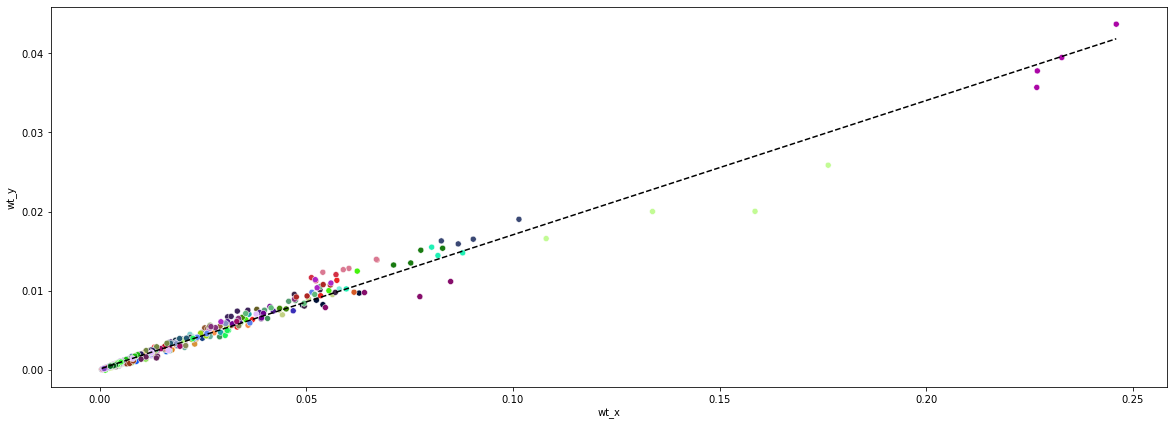

In [527]:
coef, const = fit_ols("wt", df_compare)
plot_scatter("wt", coef, const, df_compare, dict_map_colors)

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


coef: 0.16463589436820122


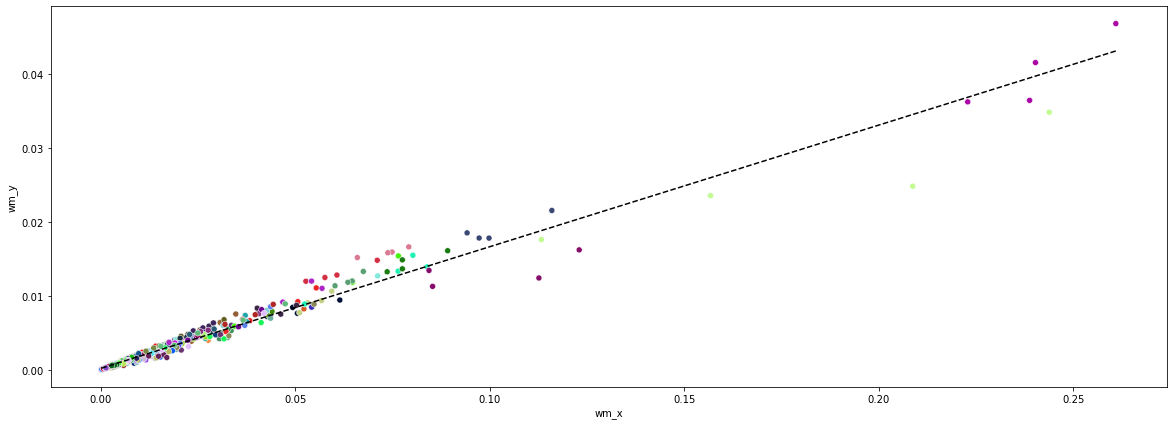

In [528]:
coef, const = fit_ols("wm", df_compare)
plot_scatter("wm", coef, const, df_compare, dict_map_colors)

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


coef: 0.17361329779777485


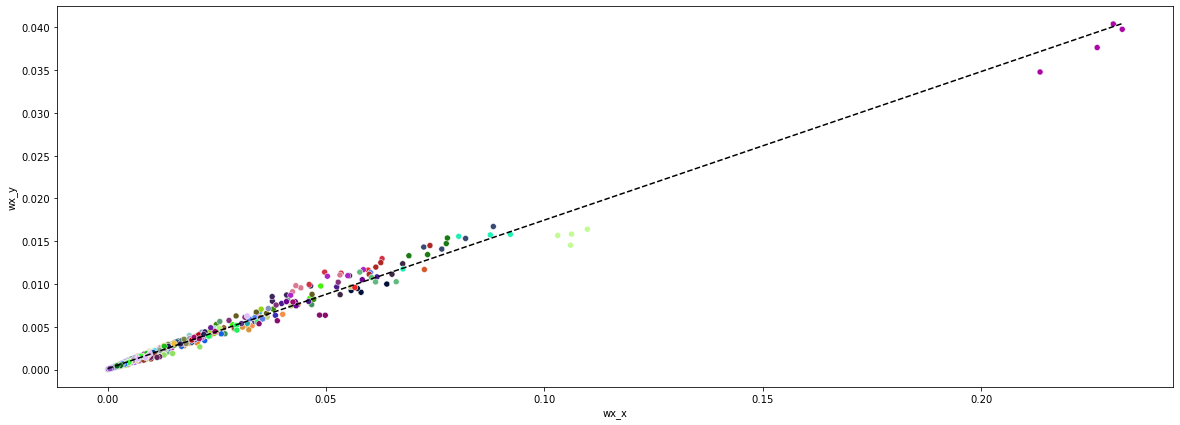

In [529]:
coef, const = fit_ols("wx", df_compare)
plot_scatter("wx", coef, const, df_compare, dict_map_colors)

#### Get correlation of data trends between processed data and Frankel Rose data

In [82]:
countries_corr = {}
for w in ["wt", "wm", "wx"]:
    countries_corr[str(w)] = dict()
    for i in range(len(list_countries)-1):
        country1 = list_countries[i]
        for j in range(i+1, len(list_countries)):
            country2 = list_countries[j]
            fr_df = FR_data[(FR_data["country_1"] == country1) & (FR_data["country_2"] == country2)][[w]]
            if fr_df.empty:
                fr_df = FR_data[(FR_data["country_1"] == country2) & (FR_data["country_2"] == country1)][[w]]
            dy_df_w = dy_df[(dy_df["country_1"] == country1) & (dy_df["country_2"] == country2)][[w]].fillna(0)
            countries_corr[str(w)][country1 + "_" + country2] = np.corrcoef(fr_df.values[:, 0], dy_df_w.values[:, 0])[0, 1]


#### average correlation between Frankel Rose data and processed data over all pairs of countries

In [83]:
print(f"average correlation on wt Trade Intensity by bilateral trade: {np.mean(list(countries_corr['wt'].values()))}")
print(f"average correlation on wm Trade Intensity by import: {np.mean(list(countries_corr['wx'].values()))}")
print(f"average correlation on wx Trade Intensity by export: {np.mean(list(countries_corr['wm'].values()))}")


average correlation on wt Trade Intensity by bilateral trade: 0.8734309524956154
average correlation on wm Trade Intensity by import: 0.5530165291321921
average correlation on wx Trade Intensity by export: 0.6425761034768724


## Analysis of economic concept data

In [473]:
def get_aggregation_countries(df):
    df_aggregate = pd.DataFrame({"date": real_GDP.index})
    for country in list_countries:
        df_country = df[df["Country"] == country][["Date", "Value"]].rename(columns={"Value": country, "Date": "date"})
        df_aggregate = pd.merge(df_aggregate, df_country, on="date", how="left")
    return df_aggregate

def get_hp(df):
    df_hp = df.copy()
    for country in list_countries:
        df_hp[country] = sm.tsa.filters.hpfilter(df[country].dropna(), 1600)[0]
    return df_hp

def get_concept_corr(df, name):
    corr_df = pd.DataFrame(columns=["period", "country_1", "country_2", name])
    nb_countries = len(list_countries)
    periods = [
        (1, "1959-01-01", "1967-07-01"),
        (2, "1967-10-01", "1976-04-01"),
        (3, "1976-07-01", "1985-01-01"),
        (4, "1985-04-01", "1993-10-01")
    ]
    index_increment = 0
    for i in range(nb_countries):
        for j in range(i+1, nb_countries):
            for (period, date1, date2) in periods:
                country_i = df.columns[i]
                country_j = df.columns[j]
                corr = df.loc[date1: date2][country_i].corr(df.loc[date1: date2][country_j])
                corr_df.loc[index_increment] = [period, country_i, country_j, corr]
                index_increment+=1
    return corr_df


In [474]:
def get_df_residuals(df):
    df["time"] = np.linspace(1, df.shape[0], df.shape[0])
    df["time_square"] = df["time"]**2
    df["quarter"] = df.index.month.map({1: 1, 4: 2, 7: 3, 10: 4})
    dummies_quarters = pd.get_dummies(df["quarter"], prefix="quarter", drop_first=True)
    df = pd.merge(df, dummies_quarters, left_on=df.index, right_on=dummies_quarters.index)
    df = df.rename(columns={"key_0": "date"}).set_index("date")
    df_residuals = df[["time"]]
    attributes_X = ["time", "time_square", "quarter_2", "quarter_3", "quarter_4"]
    for country in list_countries:
        X = df[attributes_X + [country]].dropna()[attributes_X]
        X = sm.add_constant(X)
        y = df[attributes_X + [country]].dropna()[country]
        model = sm.OLS(y, X)
        results = model.fit()
        const = results.params["const"]
        df_residuals[country] = (
            results.params["const"]
            + results.params["time"] * X["time"] 
            + results.params["time_square"] * X["time_square"] 
            + results.params["quarter_2"] * X["quarter_2"] 
            + results.params["quarter_3"] * X["quarter_3"] 
            + results.params["quarter_4"] * X["quarter_4"] 
            - y
        )
    return df_residuals.drop("time", axis=1)

### Employment data

In [459]:
employment_data_path = "/Users/victorgraff/Documents/2022:2023 ENSAE/Cours/Statapps/data_StatApp/oecd/Employment.csv"
employment = pd.read_csv(employment_data_path)
employment = employment[employment["Subject"] == 'Employed population, Aged 15 and over, All persons']
employment["Country"] = employment["Country"].replace({
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
        "New Zealand": "NewZealand",
        "Netherlands, The": 'NetherlandsThe',
    })

In [535]:
employment

,Australia,Austria,Canada,Denmark,Finland,France,Germany,Greece,Ireland,Italy,Japan,NewZealand,Norway,Portugal,Spain,Sweden,Switzerland,UnitedKingdom,UnitedStates,time,time_square,quarter
date,,,,,,,,,,,,,,,,,,,,,,
1959-01-01,NaN,NaN,8.668608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.669420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.065695,1.0,1.0,1
1959-04-01,NaN,NaN,8.673280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.680440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.078629,2.0,4.0,2
1959-07-01,NaN,NaN,8.682211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.678215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.080218,3.0,9.0,3
1959-10-01,NaN,NaN,8.685670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.680516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.081024,4.0,16.0,4
1960-01-01,NaN,NaN,8.689973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.689822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.085419,5.0,25.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,9.458758,8.363568,9.825119,7.956264,7.838120,10.207476,10.637536,8.261035,7.733289,10.035129,11.115875,7.911324,7.901360,8.474587,9.863838,8.532199,8.460883,10.378448,11.916974,248.0,61504.0,4
2021-01-01,9.471138,8.355936,9.828730,7.957539,7.839934,10.216429,10.625815,8.230785,7.731725,10.007608,11.116271,7.917536,7.907705,8.465318,9.869095,8.527241,8.444765,10.378634,11.921300,249.0,62001.0,1
2021-04-01,9.480550,8.361679,9.834848,7.971943,7.853557,10.228325,10.631294,8.270139,7.772079,10.023269,11.113989,7.928406,7.936895,8.479530,9.890571,8.541239,8.445134,10.382915,11.928167,250.0,62500.0,2


In [460]:
employment = process_concept_data(employment)

/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_6226/4263225054.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Value"] = np.log(df["Value"])
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_6226/4263225054.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = df["TIME"].astype(str).str[:4]
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_6226/4263225054.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [461]:
employment = get_aggregation_countries(employment)

In [462]:
employment = employment.set_index("date")

In [477]:
employment_diff = employment.diff(4)
employment_hp = get_hp(employment)
employment_residuals = get_df_residuals(employment)

/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_6226/1875065397.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_residuals[country] = (


In [480]:
corr_emp_hp = get_concept_corr(employment_hp, "se")
corr_emp_df = get_concept_corr(employment_diff, "de")
corr_emp_residuals = get_concept_corr(employment_residuals, "te")
corr_emp = get_concept_corr(employment, "e")

### Unemployment data

In [540]:
path_unemployment = "/Users/victorgraff/Documents/2022:2023 ENSAE/Cours/Statapps/data_StatApp/oecd/UnemployedPopulation.csv"
unemploy = pd.read_csv(path_unemployment)
unemploy = unemploy[unemploy["Subject"] == 'Unemployed population, Aged 15 and over, All persons']
unemploy["Country"] = unemploy["Country"].replace({
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
        "New Zealand": "NewZealand",
        "Netherlands, The": 'NetherlandsThe',
    })

In [541]:
unemploy = process_concept_data(unemploy)

unemploy = get_aggregation_countries(unemploy).set_index("date")

/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_6226/4208037711.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Value"] = np.log(df["Value"])
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_6226/4208037711.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = df["TIME"].astype(str).str[:4]
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_6226/4208037711.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [483]:
unemploy_diff = unemploy.diff(4)

unemploy_hp = get_hp(unemploy)
unemploy_residuals = get_df_residuals(unemploy)

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_6226/1875065397.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_residuals[country] = (


In [484]:
corr_unemp_hp = get_concept_corr(unemploy_hp, "su")
corr_unemp_df = get_concept_corr(unemploy_diff, "du")
corr_unemp_residuals = get_concept_corr(unemploy_residuals, "tu")
corr_unemp = get_concept_corr(unemploy, "u")

## Real GDP

In [485]:
real_GDP_diff = real_GDP.diff(4)
real_GDP_hp = get_hp(real_GDP)

In [486]:
corr_real_GDP_hp = get_concept_corr(real_GDP_hp, "sy")
corr_real_GDP_df = get_concept_corr(real_GDP_diff, "dy")
corr_real_GDP_residuals = get_concept_corr(real_GDP_hp, "ty")
corr_real_GDP = get_concept_corr(real_GDP, "y")

## Concatenation of all attributes

In [487]:
corr = pd.merge(corr_emp_hp, corr_emp_df, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_emp, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_emp_residuals, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_unemp_df, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_unemp_hp, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_unemp, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_unemp_residuals, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_real_GDP_hp, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_real_GDP_df, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_real_GDP, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, corr_real_GDP_residuals, on=["period", "country_1", "country_2"])
corr = pd.merge(corr, dy_df, on=["period", "country_1", "country_2"])

In [488]:
corr.to_csv("data_StatApp/processed_Data.csv")

In [489]:
compare2 = pd.merge(FR_data[["period", "country_1", "country_2", "se", "de", "te", "du", "su", "tu", "dy", "sy", "ty", "wt", "wm", "wx"]], corr, on = ["period", "country_1", "country_2"])


In [490]:
compare2.head()

,period,country_1,country_2,se_x,de_x,te_x,du_x,su_x,tu_x,dy_x,sy_x,ty_x,wt_x,wm_x,wx_x,se_y,de_y,e,te_y,du_y,su_y,u,tu_y,sy_y,dy_y,y,ty_y,wt_y,wy_real,wy_nominal,wm_y,wx_y
0,1,Austria,Denmark,0.774892,0.776907,0.894829,0.583655,0.562033,0.052004,-0.741937,-0.279533,-0.562774,0.006266,0.005094,0.006952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001279,NaN,NaN,0.001069,0.001541
1,2,Austria,Denmark,0.758608,0.637991,0.723954,0.722838,0.679858,0.688160,0.455120,0.311238,0.036392,0.009182,0.006743,0.012473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001855,NaN,NaN,0.001415,0.002414
2,3,Austria,Denmark,0.134603,0.103567,-0.263979,0.349523,0.598995,0.722506,0.352662,0.678432,0.730545,0.006140,0.004599,0.008178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001246,NaN,NaN,0.000938,0.001637
3,4,Austria,Denmark,-0.024263,-0.381224,-0.694995,0.216841,-0.066874,-0.005674,0.005491,-0.633668,-0.147953,0.005746,0.005146,0.006429,0.735753,0.80126,-0.811034,-0.701327,0.790834,0.899561,0.941691,0.912383,NaN,NaN,NaN,NaN,0.001183,NaN,NaN,0.001069,0.001311
4,1,Austria,France,0.024493,-0.252782,-0.712796,0.658234,0.513828,0.078660,0.851275,-0.124666,-0.386377,0.007480,0.010194,0.004057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001268,NaN,NaN,0.001740,0.000769


/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


coef: 1.0503630655002962


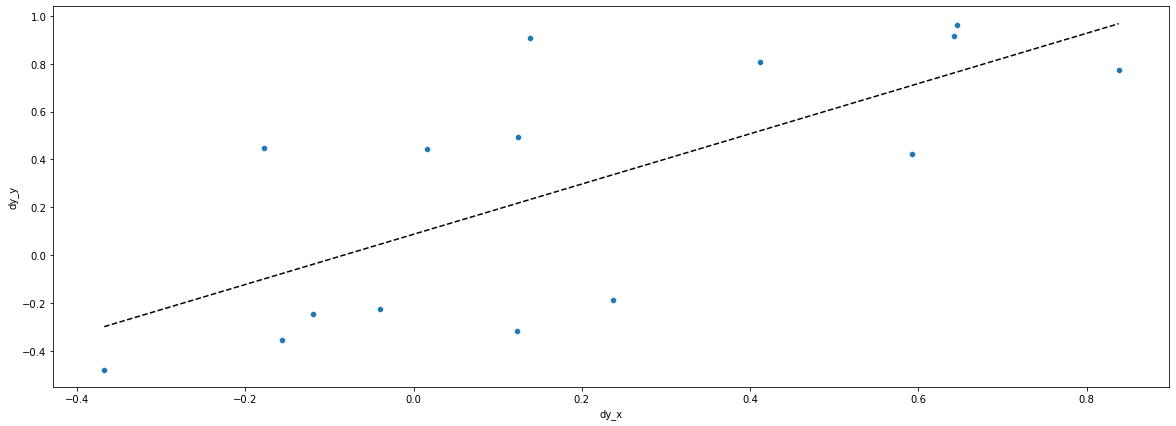

In [491]:
coef, const = fit_ols("dy", compare2)
plot_scatter("dy", coef, const, compare2)

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


coef: 0.7122776282349901


/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


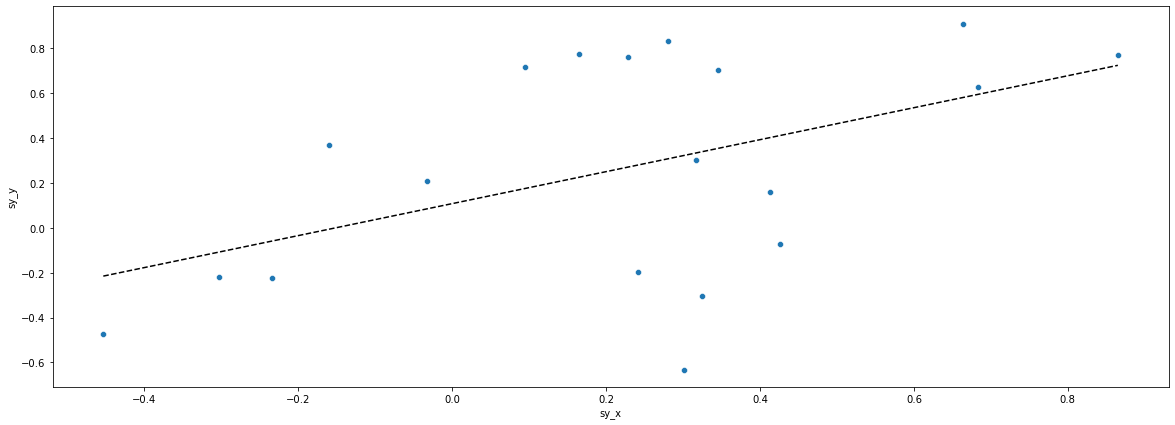

In [492]:
coef, const = fit_ols("sy", compare2)
plot_scatter("sy", coef, const, compare2)

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


coef: 0.586725709384929


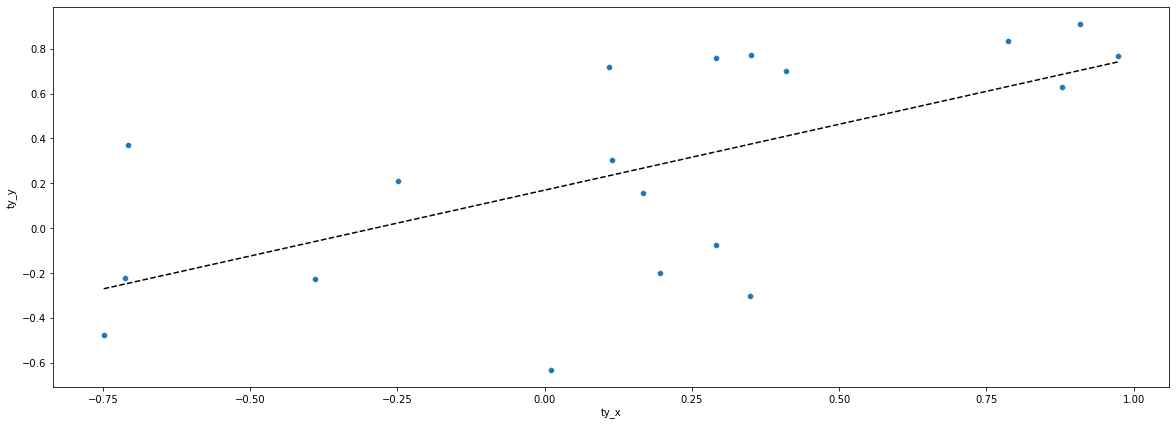

In [493]:
coef, const = fit_ols("ty", compare2)
plot_scatter("ty", coef, const, compare2)

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


coef: 0.3807819929344619


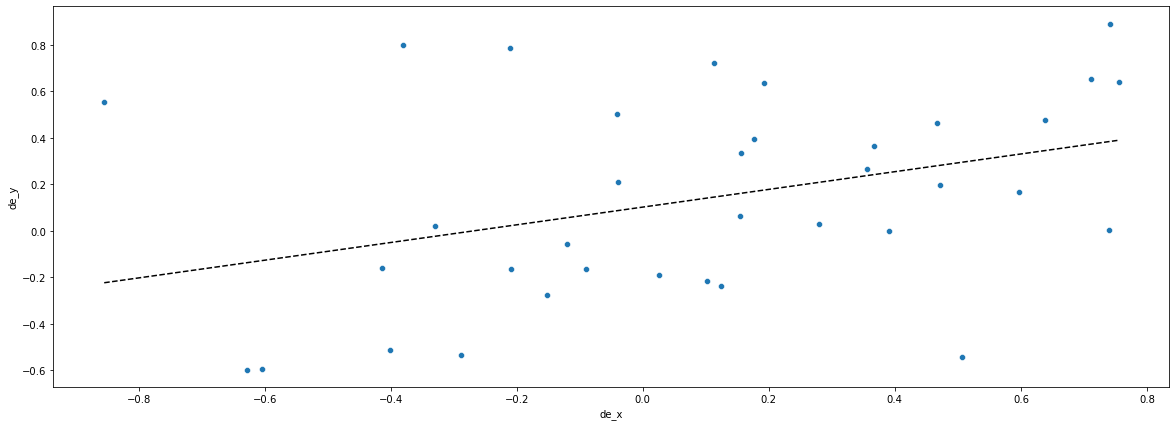

In [494]:
coef, const = fit_ols("de", compare2)
plot_scatter("de", coef, const, compare2)

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


coef: 0.22250372213344405


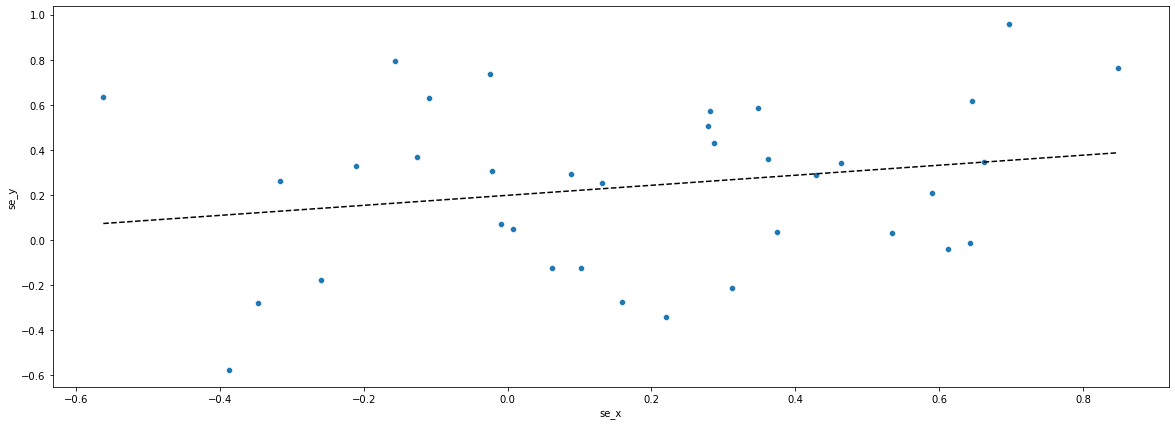

In [495]:
coef, const = fit_ols("se", compare2)
plot_scatter("se", coef, const, compare2)

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


coef: 0.3915495912649334


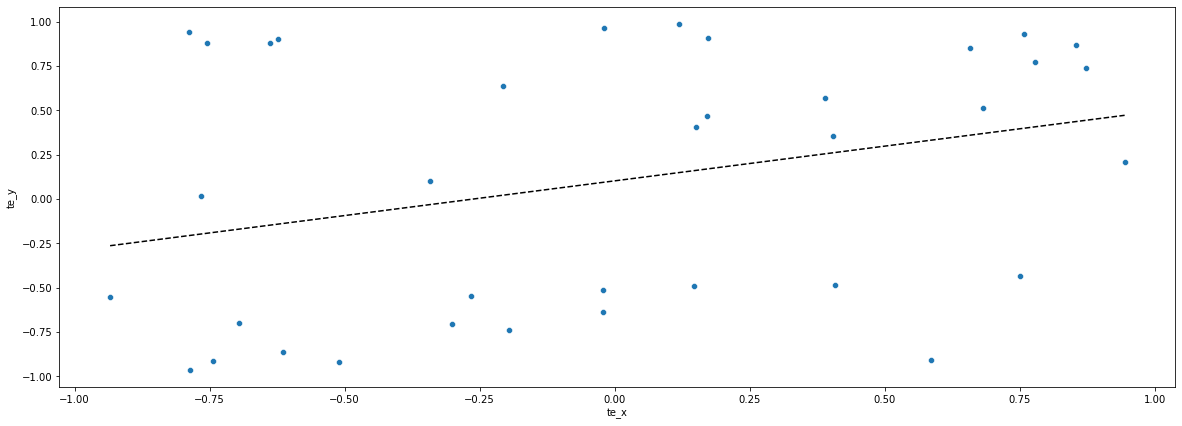

In [496]:
coef, const = fit_ols("te", compare2)
plot_scatter("te", coef, const, compare2)

coef: 0.3511861821491699


/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


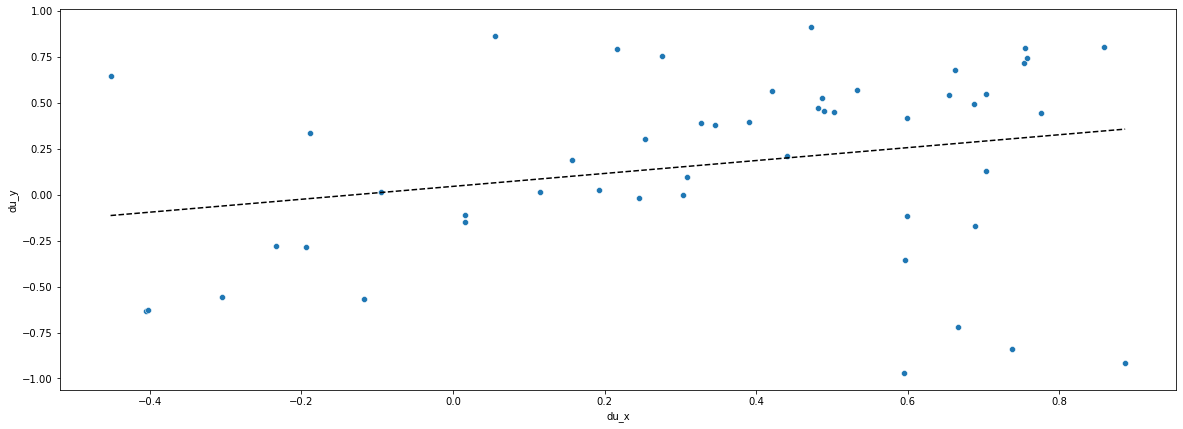

In [497]:
coef, const = fit_ols("du", compare2)
plot_scatter("du", coef, const, compare2)

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


coef: 0.33852996337700814


/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


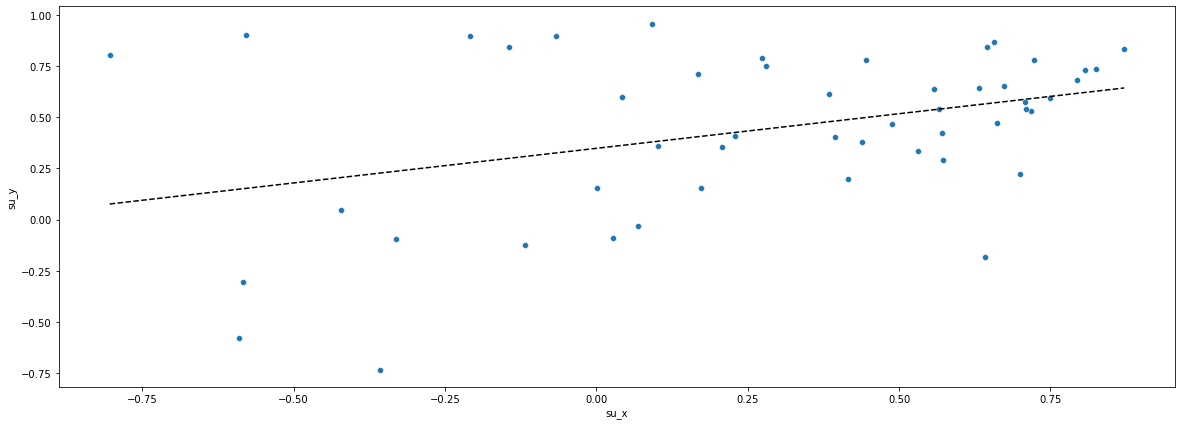

In [498]:
coef, const = fit_ols("su", compare2)
plot_scatter("su", coef, const, compare2)

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


coef: 0.5703998759189051


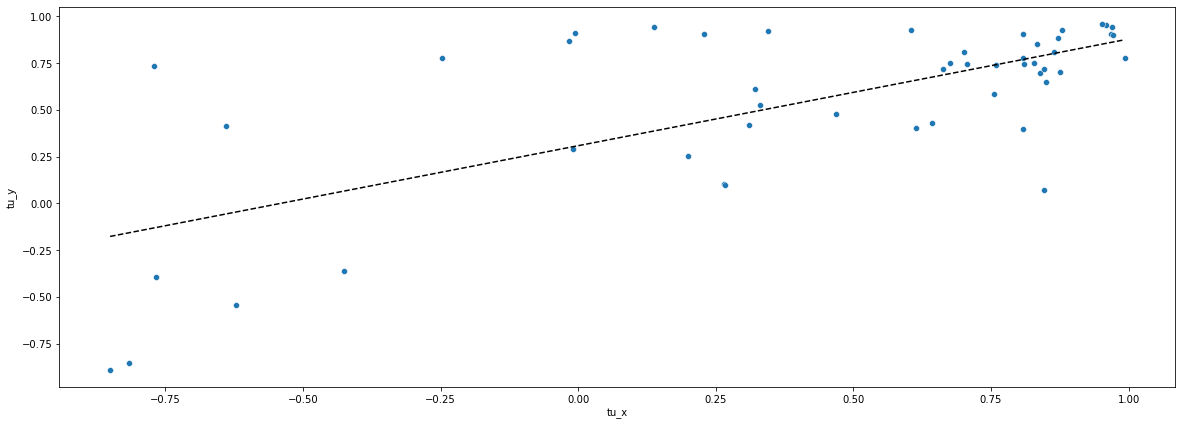

In [499]:
coef, const = fit_ols("tu", compare2)
plot_scatter("tu", coef, const, compare2)